# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 1

##### Imports

In [1]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd

# Models and metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score

# Plotting
import matplotlib.pyplot as plt

# Explaining Machine Learning models
import shap

pd.set_option('display.max_colwidth', None)

#### Variables and Functions

In [2]:
# A mapping for all features and their descriptions
FEATURES = {
   "SCHL":{
      "Description":"Educational attainment",
      "Cat":{
         "bb":"N/A (less than 3 years old)",
         "1":"No schooling completed",
         "2":"Nursery school, preschool",
         "3":"Kindergarten",
         "4":"Grade 1",
         "5":"Grade 2",
         "6":"Grade 3",
         "7":"Grade 4",
         "8":"Grade 5",
         "9":"Grade 6",
         "10":"Grade 7",
         "11":"Grade 8",
         "12":"Grade 9",
         "13":"Grade 10",
         "14":"Grade 11",
         "15":"12th grade - no diploma",
         "16":"Regular high school diploma",
         "17":"GED or alternative credential",
         "18":"Some college, but less than 1 year",
         "19":"1 or more years of college credit, no degree",
         "20":"Associate's degree",
         "21":"Bachelor's degree",
         "22":"Master's degree",
         "23":"Professional degree beyond a bachelor's degree",
         "24":"Doctorate degree"
      }
   },
   "CIT":{
      "Description":"Citizenship status",
      "Cat":{
         "1":"Born in the U.S.",
         "2":"Born in Puerto Rico, Guam, the U.S. Virgin Islands, or the Northern Marianas",
         "3":"Born abroad of American parent(s)",
         "4":"U.S. citizen by naturalization",
         "5":"Not a citizen of the U.S."
      }
   },
   "COW":{
      "Description":"Class of worker",
      "Cat":{
         "b":"N/A (less than 16 years old/NILF who last worked more than 5 years ago or never worked)",
         "1":"Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
         "2":"Employee of a private not-for-profit, tax-exempt, or charitable organization",
         "3":"Local government employee (city, county, etc.)",
         "4":"State government employee",
         "5":"Federal government employee",
         "6":"Self-employed in own not incorporated business, professional practice, or farm",
         "7":"Self-employed in own incorporated business, professional practice or farm",
         "8":"Working without pay in family business or farm",
         "9":"Unemployed and last worked 5 years ago or earlier or never worked"
      }
   },
   "ENG":{
      "Description":"Ability to speak English",
      "Cat":{
         "b":"N/A (less than 5 years old/speaks only English)",
         "1":"Very well",
         "2":"Well",
         "3":"Not well",
         "4":"Not at all"
      }
   },
   "MAR":{
      "Description":"Marital status",
      "Cat":{
         "1":"Married",
         "2":"Widowed",
         "3":"Divorced",
         "4":"Separated",
         "5":"Never married or under 15 years old"
      }
   },
   "HINS1":{
      "Description":"Insurance through a current or former employer or union",
      "Cat":{
         "1":"Yes",
         "2":"No"
      }
   },
   "HINS2":{
      "Description":"Insurance purchased directly from an insurance company",
      "Cat":{
         "1":"Yes",
         "2":"No"
      }
   },
   "HINS4":{
      "Description":"Medicaid, Medical Assistance, or any kind of government-assistance plan for those with low incomes or a disability",
      "Cat":{
         "1":"Yes",
         "2":"No"
      }
   },
   "RAC1P":{
      "Description":"Recoded detailed race code",
      "Cat":{
         "1":"White alone",
         "2":"Black or African American alone",
         "3":"American Indian alone",
         "4":"Alaska Native alone",
         "5":"American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races",
         "6":"Asian alone",
         "7":"Native Hawaiian and Other Pacific Islander alone",
         "8":"Some Other Race alone",
         "9":"Two or More Races"
      }
   },
   "SEX":{
      "Description":"Sex",
      "Cat":{
         "1":"Male",
         "2":"Female"
      }
   }
}


class FairnessReport:
   '''
   Custom class to compute a 'Fairness Report'. The Fairness report includes a measure of Statistical Parity, Equalized Odds,
   and Equalized Outcomes from an array of TRUE labels, an array of PREDICTIONS, and the class split. If the probabilities are also 
   passed to the fitter, those are included in the results table.
   '''

   def __init__(self):
        pass
    

   def fit(self, y_true, y_pred, group, pred_prob=None, index=None):
      '''
      Fitter of the class. It basically constructs the table needed for computing the different fairness metrics.

      Arguments:
      - y_true: Array of TRUE labels
      - y_pred: Array of PREDICTED labels
      - group: Partititions for the observations
      - pred_prob: The probabilities from the classifier.
      - index: Index of the observations. If passed, the index from the observations is kept, so easy comparisons can be made.
      '''

      # Create a DF with the each prediction, including group, prediction (selected) and target (true label)
      self.results_table = pd.DataFrame()
      self.results_table["group"] = group
      self.results_table["target"] = y_true
      self.results_table["selected"] = y_pred
      if type(pred_prob) != None:
         self.results_table["pred_prob"] = pred_prob[:,1]
      if type(index) != None:
         try:
            self.results_table.index = index
         except:
            print("Could not include index. Omitted.")
      
      return
      

   def compute(self):
      '''
      Compute the Fairness metrics, and show group-wise Confusion Matrices along with computed Statistical Parity, Equalized Odds and Equalized Outcomes.
      '''

      # Extract TPR and FPR per group
      rates = {1: {}, 2: {}}

      # Colormaps
      colors = [plt.cm.Blues, plt.cm.Reds]

      # Plot confusion matrices for context
      fig, ax = plt.subplots(2, 2, figsize=(12,12), dpi=300)

      # Populate the subplots
      for ix in range(2):
         group = ix+1 # Group code (1: Male, 2: Female)
         # Compute the confusion matrix
         cm = confusion_matrix(self.results_table.loc[self.results_table.group == group, "target"], self.results_table.loc[self.results_table.group == group, "selected"],
                                                      normalize=None)
         # Compute the row-wise normalized matrix
         cm_norm = confusion_matrix(self.results_table.loc[self.results_table.group == group, "target"], self.results_table.loc[self.results_table.group == group, "selected"],
                                                      normalize="true")
         # Extract True Positive Rate (TPR) and False Positive Rate (FPR) from the Confusion Matrix
         rates[group]["TPR"] = cm_norm[1,1]
         rates[group]["FPR"] = cm_norm[0,1]

         # Display both CMs
         disp1 = ConfusionMatrixDisplay(cm)
         disp2 = ConfusionMatrixDisplay(cm_norm)
         disp1.plot(cmap=colors[ix], ax=ax[ix,0], values_format = 'g')
         disp2.plot(cmap=colors[ix], ax=ax[ix,1])
         ax[ix,0].set_title(f'Group {group}')
         ax[ix,1].set_title(f'Group {group} - Row Norm.')
         
      ax[0,0].set_xlabel("")
      ax[0,1].set_xlabel("")
      ax[0,1].set_ylabel("")
      ax[1,1].set_ylabel("")
      fig.suptitle("Confusion Matrices per Group", fontweight='bold')
      plt.show();

      # Statistical parity: Prob. of being selected given the group
      ## Per each group, we look at the number of TRUE Predictions and divide by the total number of people in that group
      G1 = len(self.results_table.loc[(self.results_table.group == 1) & (self.results_table.selected)]) / len(self.results_table.loc[(self.results_table.group == 1)])
      G2 = len(self.results_table.loc[(self.results_table.group == 2) & (self.results_table.selected)]) / len(self.results_table.loc[(self.results_table.group == 2)])
      print(f"Statistical Parity: {G1 == G2} -> (P(s=1 | G=1): {G1:.3f} & P(s=1 | G=2): {G2:.3f})")

      # Equalized odds: both TPR and FPR are equal for both groups
      print(f'Equalized Odds: {(rates[1]["TPR"] == rates[2]["TPR"]) & (rates[1]["FPR"] == rates[2]["FPR"])} -> TPR Group 1: {rates[1]["TPR"]:.3f} & TPR Group 2: {rates[2]["TPR"]:.3f} & FPR Group 1: {rates[1]["FPR"]:.3f} & FPR Group 2: {rates[2]["FPR"]:.3f}')

      # Equalized outcomes: Given the prediction, trues are independent of the group
      ## Per each group:
         ### we look at the True Positives (TP, i.e., the number of people that were predicted POSITIVE AND had POSITIVE TRUE label) and divide by the number of predicted TRUE in that group.
         ### Then we look at the False Negatives (FN, i.e., the number of people that had POSITIVE LABEL but were NOT predicted POSITIVE)
      G1_pred_pos = len(self.results_table.loc[(self.results_table.group == 1) & (self.results_table.target) & (self.results_table.selected)]) / len(self.results_table.loc[(self.results_table.group == 1) & (self.results_table.selected)])
      G2_pred_pos = len(self.results_table.loc[(self.results_table.group == 2) & (self.results_table.target) & (self.results_table.selected)]) / len(self.results_table.loc[(self.results_table.group == 2) & (self.results_table.selected)])
      G1_pred_neg = len(self.results_table.loc[(self.results_table.group == 1) & (self.results_table.target) & (~self.results_table.selected)]) / len(self.results_table.loc[(self.results_table.group == 1) & (~self.results_table.selected)])
      G2_pred_neg = len(self.results_table.loc[(self.results_table.group == 2) & (self.results_table.target) & (~self.results_table.selected)]) / len(self.results_table.loc[(self.results_table.group == 2) & (~self.results_table.selected)])
      print(f"Equalized Outcomes: {(G1_pred_pos == G2_pred_pos) & (G1_pred_neg == G2_pred_neg)} -> P(T=1 | G=1,S=1): {G1_pred_pos:.3f} & P(T=1 | G=2, S=1): {G2_pred_pos:.3f} P(T=1 | G=1, S=0): {G1_pred_neg:.3f} & P(T=1 | G=2, S=0): {G2_pred_neg:.3f}")

      return


   def get_results_table(self):
      '''
      Return the results table for inspection.
      '''
      return self.results_table


   def plot_roc_curves(self, highlight={}):
      '''
      Plot the group-wise ROC curves.
      '''

      if "pred_prob" not in self.results_table.columns:
         raise Exception("The predicted probabilities were not passed to the fitter.")
      
      # Plot ROC curve
      plt.figure(figsize=(8,8), dpi=300)

      # Color list
      colormap = ["darkblue", "darkred", "darkmagenta", "darkcyan", "darksalmon", "darkkhari"]

      # Predict probabilities for the test set, group-wise
      for ix, group in enumerate(self.results_table["group"].unique()):
         group_subset = self.results_table[self.results_table["group"] == group]
         # Compute ROC curve and ROC area for each group
         fpr, tpr, th = roc_curve(group_subset.target, group_subset.pred_prob)
         roc_auc = roc_auc_score(group_subset.target, group_subset.pred_prob)
         # Plot the ROC curve
         plt.plot(fpr, tpr, color=colormap[ix], lw=2, label=f'ROC curve (Group {group})\n(area = {roc_auc:.2f})')
         # If a threshold should be highlighted
         if group in highlight:
            # Get the threshold point
            t = highlight[group]
            # Find the closest threshold to the requested point
            idx = (np.abs(th - t)).argmin()
            plt.plot(fpr[idx], tpr[idx], marker='X', markersize=10, color=colormap[ix])
            plt.vlines(fpr[idx], 0, tpr[idx], colors=colormap[ix], linestyles='dashed', label='', alpha=0.5)
            plt.text(fpr[idx], tpr[idx]/2, f"{fpr[idx]:.2f}", color="gray", rotation="vertical")
            plt.hlines(tpr[idx], 0, fpr[idx], colors=colormap[ix], linestyles='dashed', label='', alpha=0.5)
            plt.text(fpr[idx]/2, tpr[idx], f"{tpr[idx]:.2f}", color="gray", rotation="horizontal")


      # Plot the straight line
      plt.plot([0, 1], [0, 1], color='green', lw=1, linestyle='--')
      
      # Format the plot
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.0])
      plt.xlabel('False Positive Rate', fontweight='bold')
      plt.ylabel('True Positive Rate', fontweight='bold')
      plt.title('Receiver Operating Characteristic (ROC)', fontweight='bold', fontsize=16)
      plt.legend(loc="lower right")
      plt.show();

      return
         

class ExplainabilityReport:
   '''
   Custom class to provide explainability from feature importance in a model.

   Arguments:
    - feature_coef: Array with the coefficients for the features in the model
    - feature_names: Array with the coded names for the features, in the same order as passed in feature_coef.
    - feat_description: Map with human-readable description for the coded features.
    - mode_name: Model name ID for plot title.
   '''

   def __init__(self, feature_coef, feature_names, feat_description=None, model_name=""):

      # For nice plot titles
      self.model_name = model_name
      # Calculate the absolute magnitude of coefficients
      abs_coefficients = np.abs(feature_coef)
      # Normalize the coefficients to get their relative importance
      normalized_coefficients = abs_coefficients / np.sum(abs_coefficients)
      self.feature_importance = pd.DataFrame()
      self.feature_importance["Feature"] = feature_names
      self.feature_importance["Import. (%)"] = normalized_coefficients.round(4) * 100
      self.feature_importance["Coef."] = feature_coef

      if feat_description:
         # Add the description for easy context
         descriptions = []
         for ix, row in self.feature_importance.iterrows():
               try:
                  k, v = row["Feature"].split("_")
                  desc = feat_description[k]["Description"] + ": " + feat_description[k]["Cat"][v]
               except:
                  desc = None
               descriptions.append(desc)

         self.feature_importance["Desc."] = descriptions
      
      # Order table by feature importance
      self.feature_importance = self.feature_importance.sort_values("Import. (%)", ascending=False)
      
      return


   def get_feature_importance(self):
      # Return the feature importance table
      return self.feature_importance.sort_values("Import. (%)", ascending=False)


   def plot_feature_importance(self):
      # Create a diverging horizontal bar plotfg
      fig, ax = plt.subplots(figsize=(12,12), dpi=300)

      # Invert the order of the feature importance so the most important features come on top
      feature_importance = self.feature_importance.sort_values("Import. (%)", ascending=True)
      feature_importance = feature_importance[feature_importance["Import. (%)"] >= 1]
      bar_colors = ['red' if score < 0 else 'blue' for score in feature_importance["Coef."]]

      bars = ax.barh(feature_importance["Feature"], feature_importance["Coef."], color=bar_colors)

      # Add importance %
      for bar, score, importance in zip(bars, feature_importance["Coef."], feature_importance["Import. (%)"]):
         if score < 0:
            ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{importance/100:.1%}',
                     va='center', ha='left', color='black', fontsize=10, fontweight='bold')
         else:
            ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{importance/100:.1%}',
                     va='center', ha='right', color='white', fontsize=10, fontweight='bold')

      # Add title and labels
      ax.set_title(f'Feature Importance\n{self.model_name}', fontweight="bold", fontsize=16)
      ax.set_xlabel('Importance Score', fontsize=12, fontweight="bold")
      ax.set_ylabel("Feature", fontsize=12, fontweight="bold")
      ax.text(0.5, 0,"Features with less than 1%\nimportance are not displayed.", horizontalalignment="center", fontsize=16, color="white", bbox=dict(facecolor='black', alpha=0.9))

      # Add grid
      ax.grid(True, axis='x', linestyle='--', alpha=0.7)

      # Show plot
      plt.show();


def report_metrics(y_true, y_pred, model_name=""):
   '''
   Function assess a model's prediction main metrics (accuracy, F1-Score, Recall, Precision and Confusion Matrix)
   '''

   # Let's get some metrics for the model
   print(classification_report(y_true, y_pred))

   disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred, normalize="true"))
   disp.plot(cmap=plt.cm.Greens)
   plt.title(f"Confusion Matrix\n{model_name}", fontweight='bold', fontsize=16)
   plt.show();

def find_counterfactual(X_test, predic_results, feature_priority, feat_description=None):
    '''
    Custom function to find a conterfactual example by looking at observations with different prediction outcome and least possible differences in feature space.
    '''

    # Sort the observations by feature importance, so similar observations are contiguos
    observations = X_test.sort_values(feature_priority)
    observations = observations[feature_priority] # We re-arrange the columns from higher importance to lower
    # Convert booleans to integers for easy euclidean calculation
    observations = observations.astype(int)
    # Merge the observations and features with the results from the model's prediction
    merged = observations.merge(predic_results, how="left", left_index=True, right_index=True)
    ### We will use Euclidean distance as a measure of how similar two observations are
    # Remove AGE from the euclidean distance calculation
    euclideand_cols = feature_priority.copy()
    euclideand_cols.remove("AGEP")
    # Extract indexes for similar observations with different predictions
    ixs = None
    min_diff = np.inf
    # Loop over the observations to find counterfactuals
    for i in range(len(merged)-1):
        # Check if their prediction is different
        if merged.iloc[i].selected != merged.iloc[i+1].selected:
            # Check how different the two observations are
            obsA = merged.loc[merged.index[i], euclideand_cols]
            obsB = merged.loc[merged.index[i+1], euclideand_cols]
            if merged.loc[merged.index[i], "AGEP"] != merged.loc[merged.index[i+1], "AGEP"]:
                obsA["AGE"] = 1
                obsB["AGE"] = 0
            euclidean_distance = np.linalg.norm(obsA - obsB)
            
            if euclidean_distance < min_diff:
                ixs = [i, i+1]
                min_diff = euclidean_distance

    # We transpose the results for easier visibility
    results = merged.iloc[ixs].T
    # If the feature description is available, we use it for better context
    descriptions = []
    if feat_description:
        # For each feature
        for ix, row in results.iterrows():
            # If the observations differ
            if row.iloc[0] != row.iloc[1]:
                try:
                    k, v = ix.split("_")
                    desc = feat_description[k]["Description"] + ": " + feat_description[k]["Cat"][v]
                except:
                    desc = "N/A"
            else:
              desc = ""

            descriptions.append(desc)
    
        results["Desc."] = descriptions

    return results

### Dataset load and pre-process

In [3]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

# Random seed for reproducibility
seed = 0
np.random.seed(seed=seed)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df["SCHL"] = df["SCHL"].astype(int)
    df["COW"] = df["COW"].astype(int)
    df["ENG"] = df["ENG"].fillna(0).astype(int)
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex

data, data_original, target, group = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0) ## SHOULD WE CHANGE THE SEED?

# Task 1 (Classifiers and fairness considerations)
## 1.1 White-box model: Logistic Regression

              precision    recall  f1-score   support

       False       0.76      0.71      0.73     17488
        True       0.78      0.82      0.80     21645

    accuracy                           0.77     39133
   macro avg       0.77      0.76      0.77     39133
weighted avg       0.77      0.77      0.77     39133



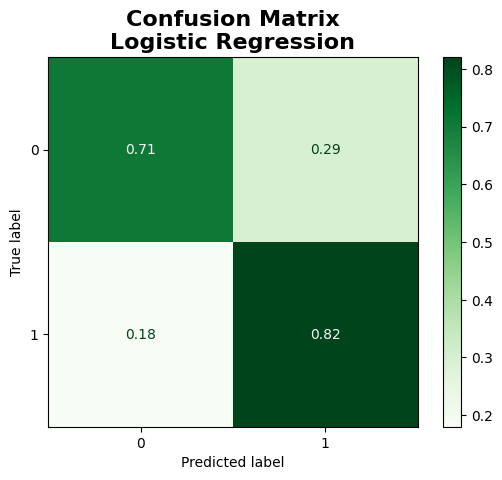

In [4]:
# Feature processing
## Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Train the model
lr = LogisticRegression(solver="newton-cholesky")
lr.fit(X_train_scaled, y_train)

# Get the results
y_hat = lr.predict(X_test_scaled)
pred_probs = lr.predict_proba(X_test_scaled)

# Get the score metrics and Confusion Matrix
report_metrics(y_test, y_hat, model_name = "Logistic Regression")

## 1.2 Fairness assessment

We use our FairnessReport class to look at the group-wise results and check for fairness.

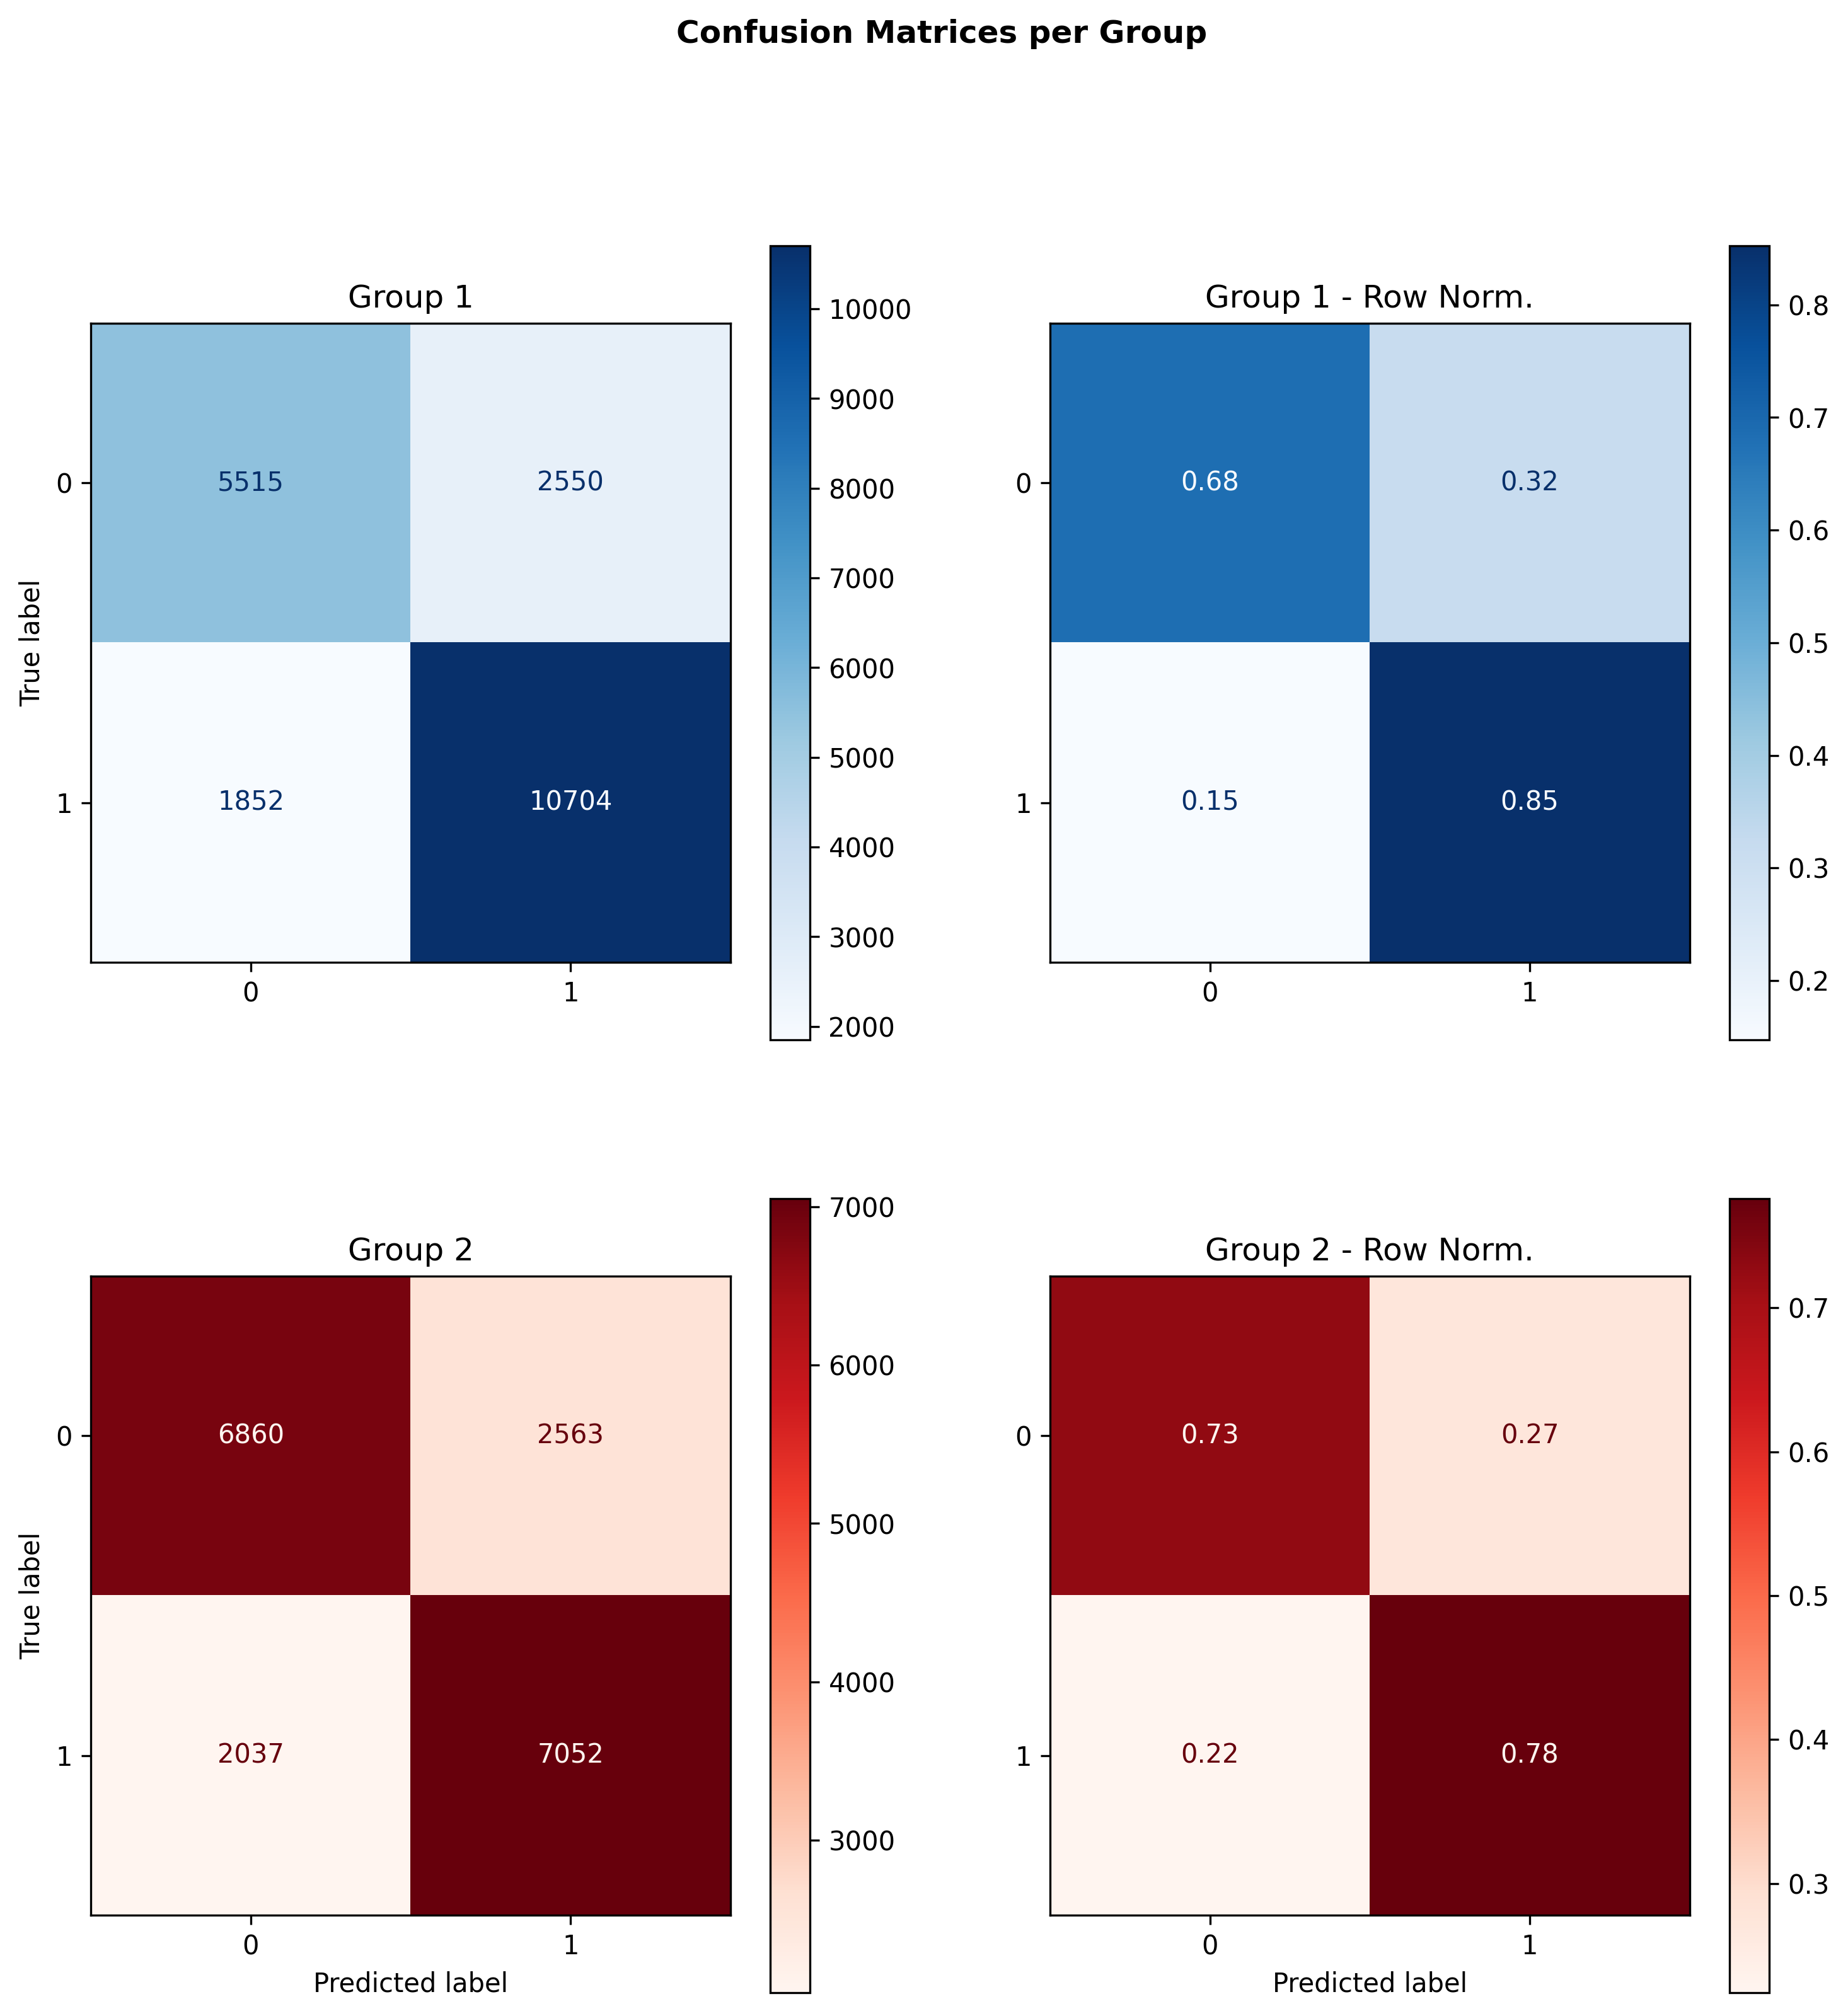

Statistical Parity: False -> (P(s=1 | G=1): 0.643 & P(s=1 | G=2): 0.519)
Equalized Odds: False -> TPR Group 1: 0.853 & TPR Group 2: 0.776 & FPR Group 1: 0.316 & FPR Group 2: 0.272
Equalized Outcomes: False -> P(T=1 | G=1,S=1): 0.808 & P(T=1 | G=2, S=1): 0.733 P(T=1 | G=1, S=0): 0.251 & P(T=1 | G=2, S=0): 0.229


In [5]:
fr = FairnessReport()
fr.fit(y_true = y_test, y_pred = y_hat, group = group_test, pred_prob = pred_probs, index=X_test.index)
fr.compute()

### 1.2.1 ROC Curves per group

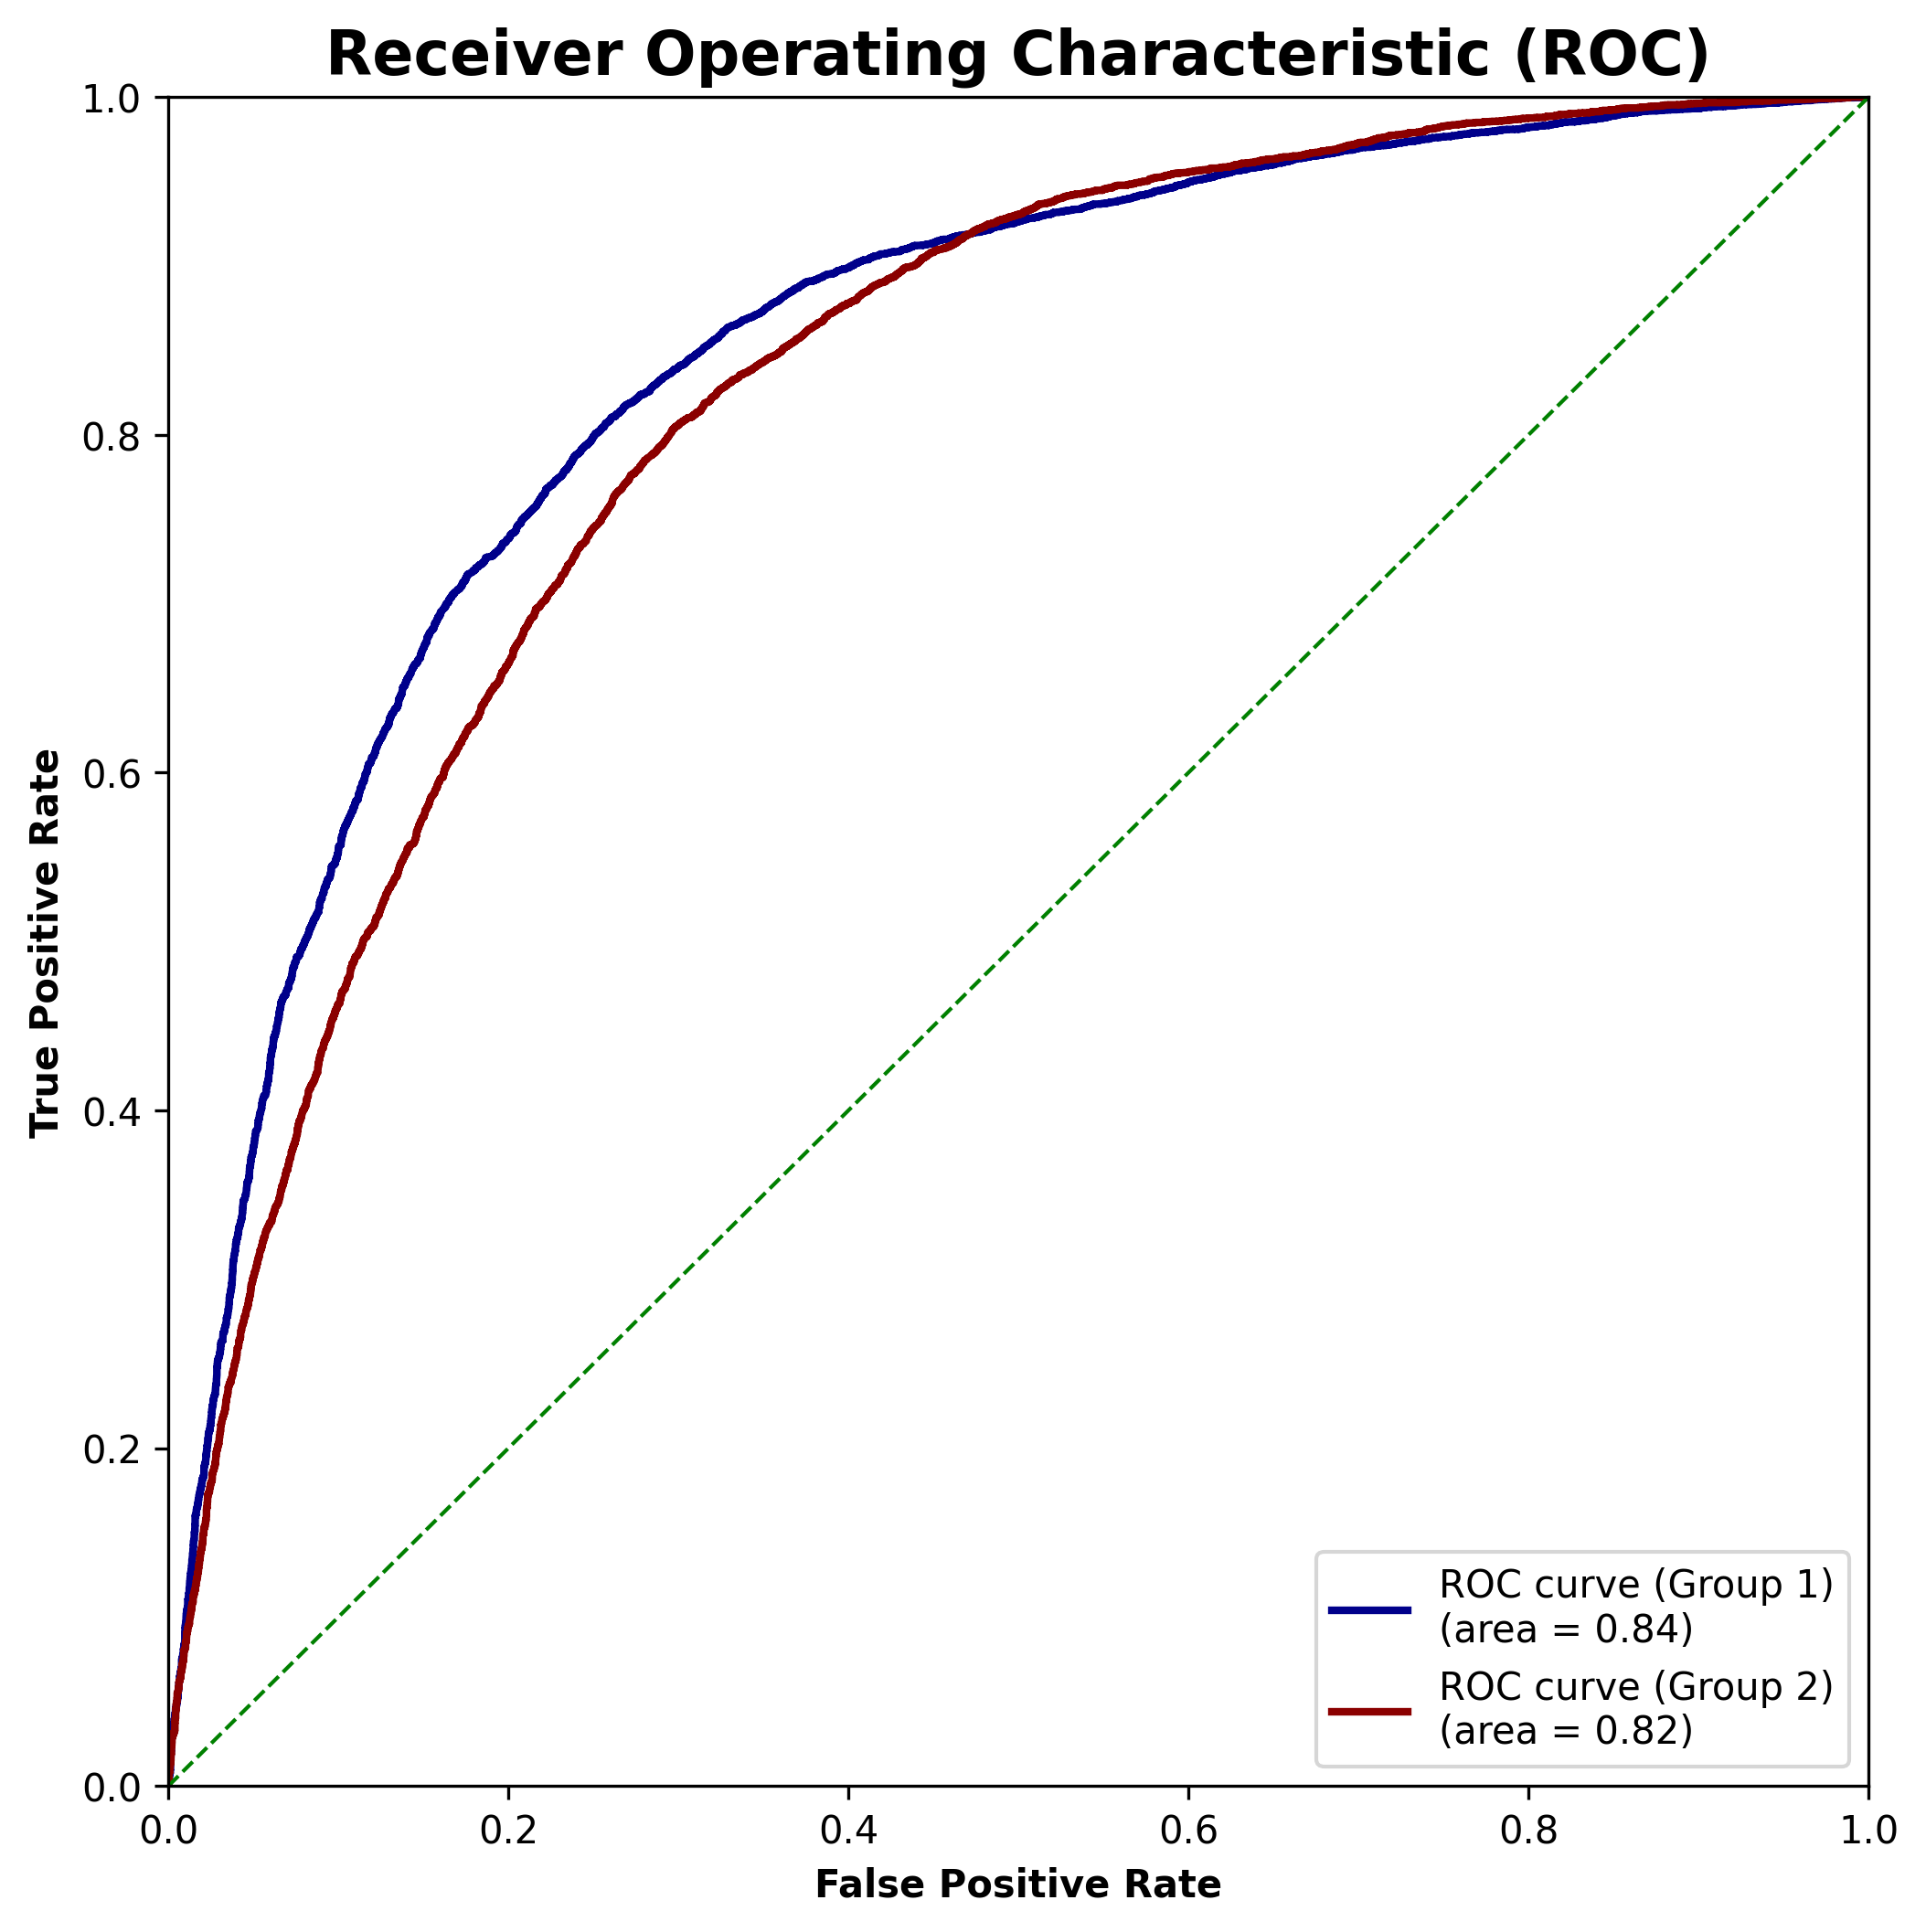

In [6]:
fr.plot_roc_curves()

## 1.3 Ensuring Statistical Parity a posteriori

Since our model predicts TRUE with different rates, we will ensure statistical parity by turning those predictions closer to the threshold to TRUE, for the minority group

Let's start by looking at the table of results, along with the probabilities returned by our Logistic Regression model

In [7]:
# We retrieve the table of results
results = fr.get_results_table()
results.head()

,group,target,selected,pred_prob
309375,1,True,True,0.863905
197073,1,False,True,0.890928
306289,2,False,True,0.602645
173749,2,True,True,0.564038
57936,1,True,True,0.848717


Let's summarize the results per group:

In [8]:
# We can look at the results summmary, to look at the disparity
results_per_group = results[["group", "selected"]].groupby("group").sum("selected")
results_per_group

,selected
group,
1,13254
2,9615


Let's calculate the disparity

In [9]:
minority_group = results_per_group.idxmin().values[0]
majority_group = results_per_group.idxmax().values[0]
diff = results_per_group.selected.max() - results_per_group.selected.min()

print(f"The minority group is {minority_group}, with {diff} less observations predicted as TRUE.")

The minority group is 2, with 3639 less observations predicted as TRUE.


### Method 1: Reduce the number of TRUE predictions for the majority group to match the minority

In [10]:
sorted_results = results[(results.group == majority_group) & (results.selected == True)].sort_values("pred_prob", ascending=True)
ix = sorted_results[:diff].index

results_method1 = results.copy()

results_method1.loc[ix, "selected"] = False

In [11]:
# We can look at the results summmary, to look at the disparity
results_per_group_m1 = results_method1[["group", "selected"]].groupby("group").sum("selected")
results_per_group_m1

,selected
group,
1,9615
2,9615


              precision    recall  f1-score   support

       False       0.69      0.78      0.73     17488
        True       0.80      0.71      0.76     21645

    accuracy                           0.75     39133
   macro avg       0.75      0.75      0.75     39133
weighted avg       0.75      0.75      0.75     39133



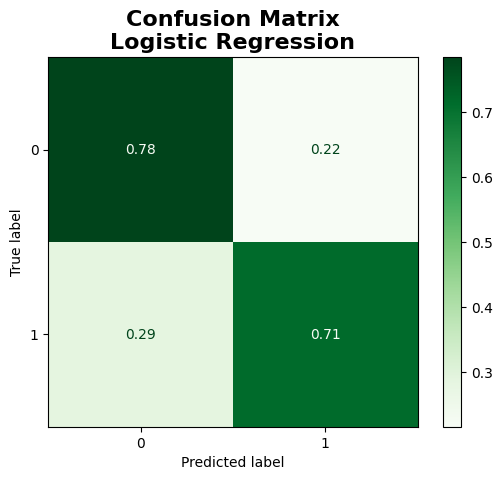

In [12]:
# Let's get some metrics for the model
report_metrics(y_true=results_method1.target, y_pred=results_method1.selected, model_name="Logistic Regression")

We can observe that with method 1, the accuracy dropped only 2 percent, while the TPR decreased from 0.82 to 0.71, meaning that we lost some TRUE positives from the switching labels on the majority group. Nevertheless, the FPR also decreased from 0.29 to 0.22, meaning that many of the flipped labels are were incorrect predictions.

### Method 2: Increase the number of positive predictions for the minority group

We can now sort the results for the minotirity group observations that were not predicted TRUE, and pick the closest ones to the threshold, and flip their prediction to achieve statistical parity.

In [13]:
sorted_results = results[(results.group == minority_group) & (results.selected == False)].sort_values("pred_prob", ascending=False)
ix = sorted_results.iloc[:diff].index

new_th = sorted_results.loc[ix[-1], "pred_prob"]

results_method2 = results.copy()

results_method2.loc[ix, "selected"] = True

print(f"We flip {diff} predictions, reducing the threhsold for group {minority_group} from 0.5 to {new_th:.2f}.")

We flip 3639 predictions, reducing the threhsold for group 2 from 0.5 to 0.26.


Let's recalculate the number of predictions as TRUE per group, and re compute the main metrics.

In [14]:
# We can look at the results summmary, to look at the disparity
results_per_group = results_method2[["group", "selected"]].groupby("group").sum("selected")
results_per_group

,selected
group,
1,13254
2,13254


              precision    recall  f1-score   support

       False       0.81      0.58      0.68     17488
        True       0.72      0.89      0.80     21645

    accuracy                           0.75     39133
   macro avg       0.76      0.73      0.74     39133
weighted avg       0.76      0.75      0.74     39133



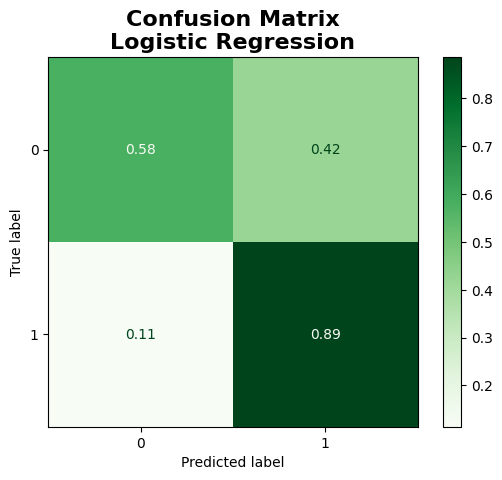

In [15]:
# Let's get some metrics for the model
report_metrics(results_method2.target, results_method2.selected, model_name="Logistic Regression")

We can observe that accuracy dropped only 2 percent, while the TPR increased from 0.82 to 0.89, meaning that we were able to capture more TRUE positives from the switching labels on the minority group. Nevertheless, the FPR also increased from 0.29 to 0.42, meaning that many of the flipped labels are now INCORRECT predictions.

### Let's look the ROC curve with the separated threhsolds

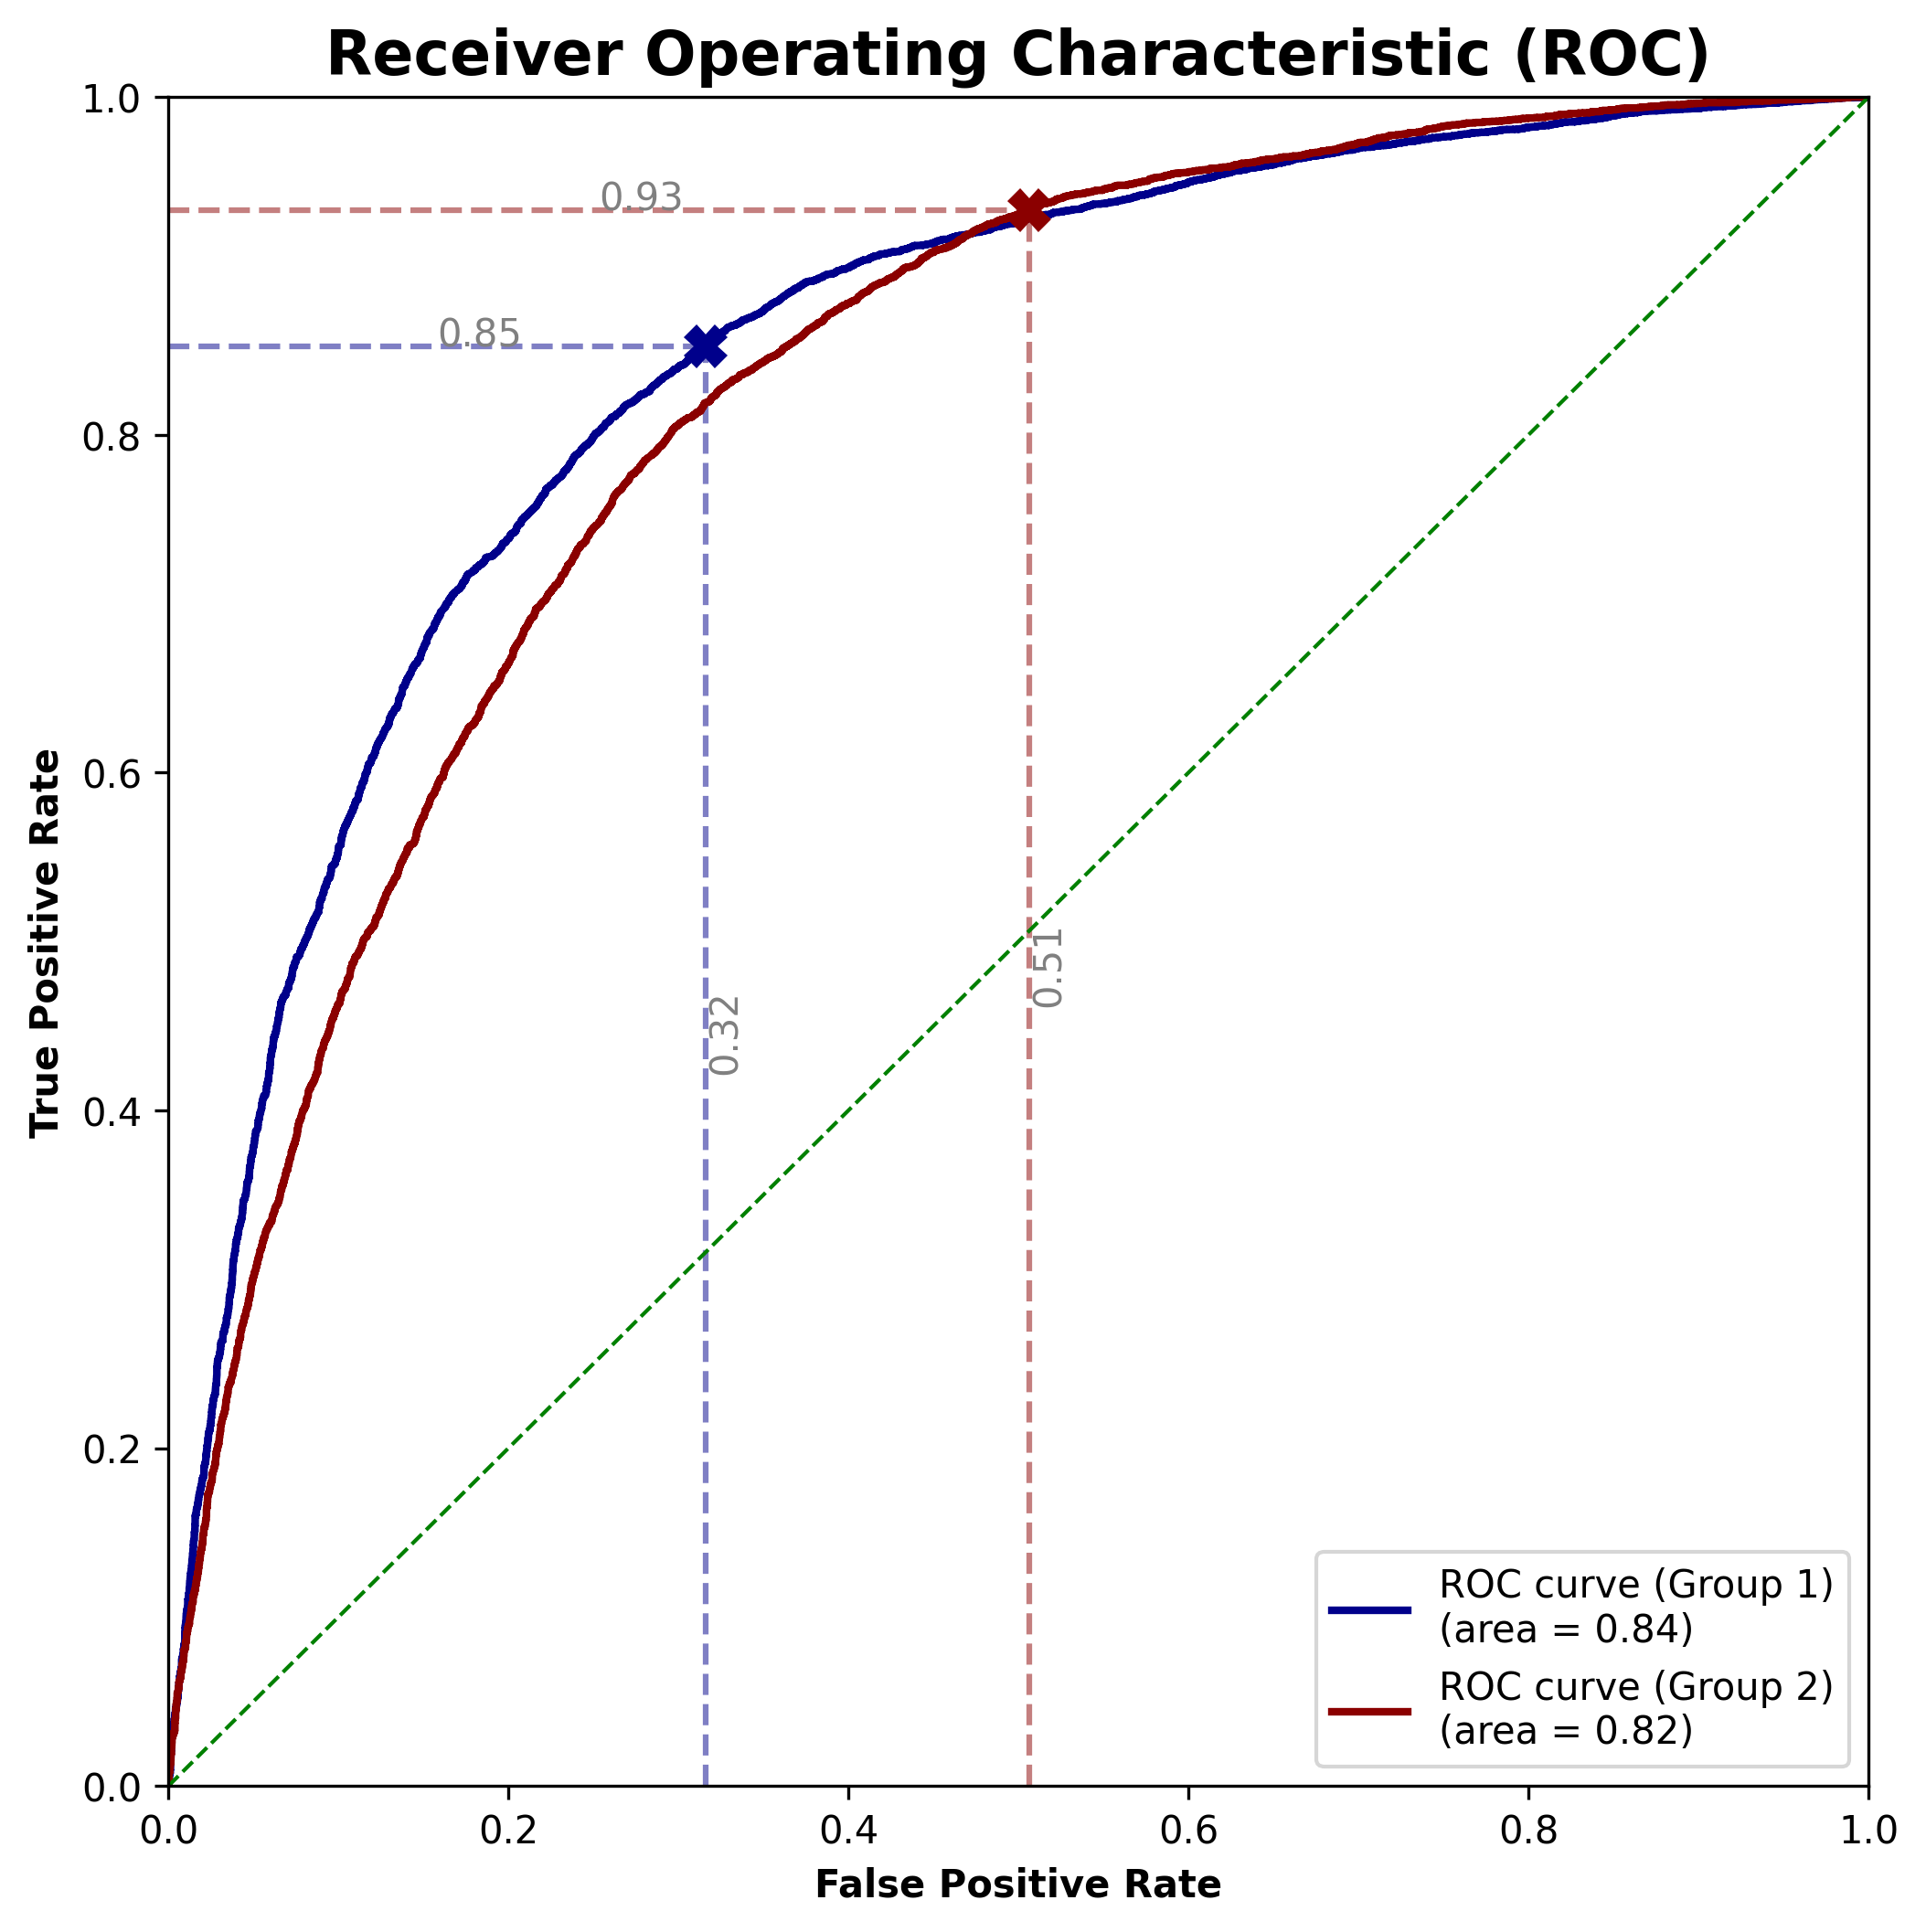

In [16]:
# We plot the group-wise ROC curves, highlighting the thresholds used for prediction for each group. 
fr.plot_roc_curves(highlight={1: 0.50, 2: new_th})

## 1.1 Black-box model: Random Forest

              precision    recall  f1-score   support

       False       0.77      0.72      0.74     17488
        True       0.78      0.83      0.80     21645

    accuracy                           0.78     39133
   macro avg       0.78      0.77      0.77     39133
weighted avg       0.78      0.78      0.78     39133



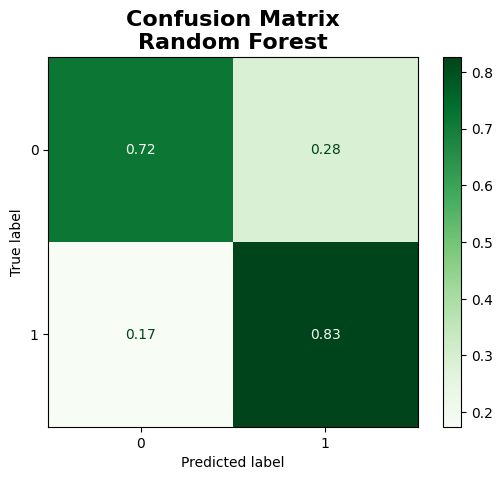

In [17]:
# Train the model
rf = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight="balanced_subsample", n_jobs=-1, verbose=0, random_state=seed)
rf.fit(X_train, y_train)

# Get the results
y_hat = rf.predict(X_test)
pred_probs = rf.predict_proba(X_test)

# Let's get some metrics for the model
report_metrics(y_test, y_hat, model_name="Random Forest")

## 1.2 Fairness assessment

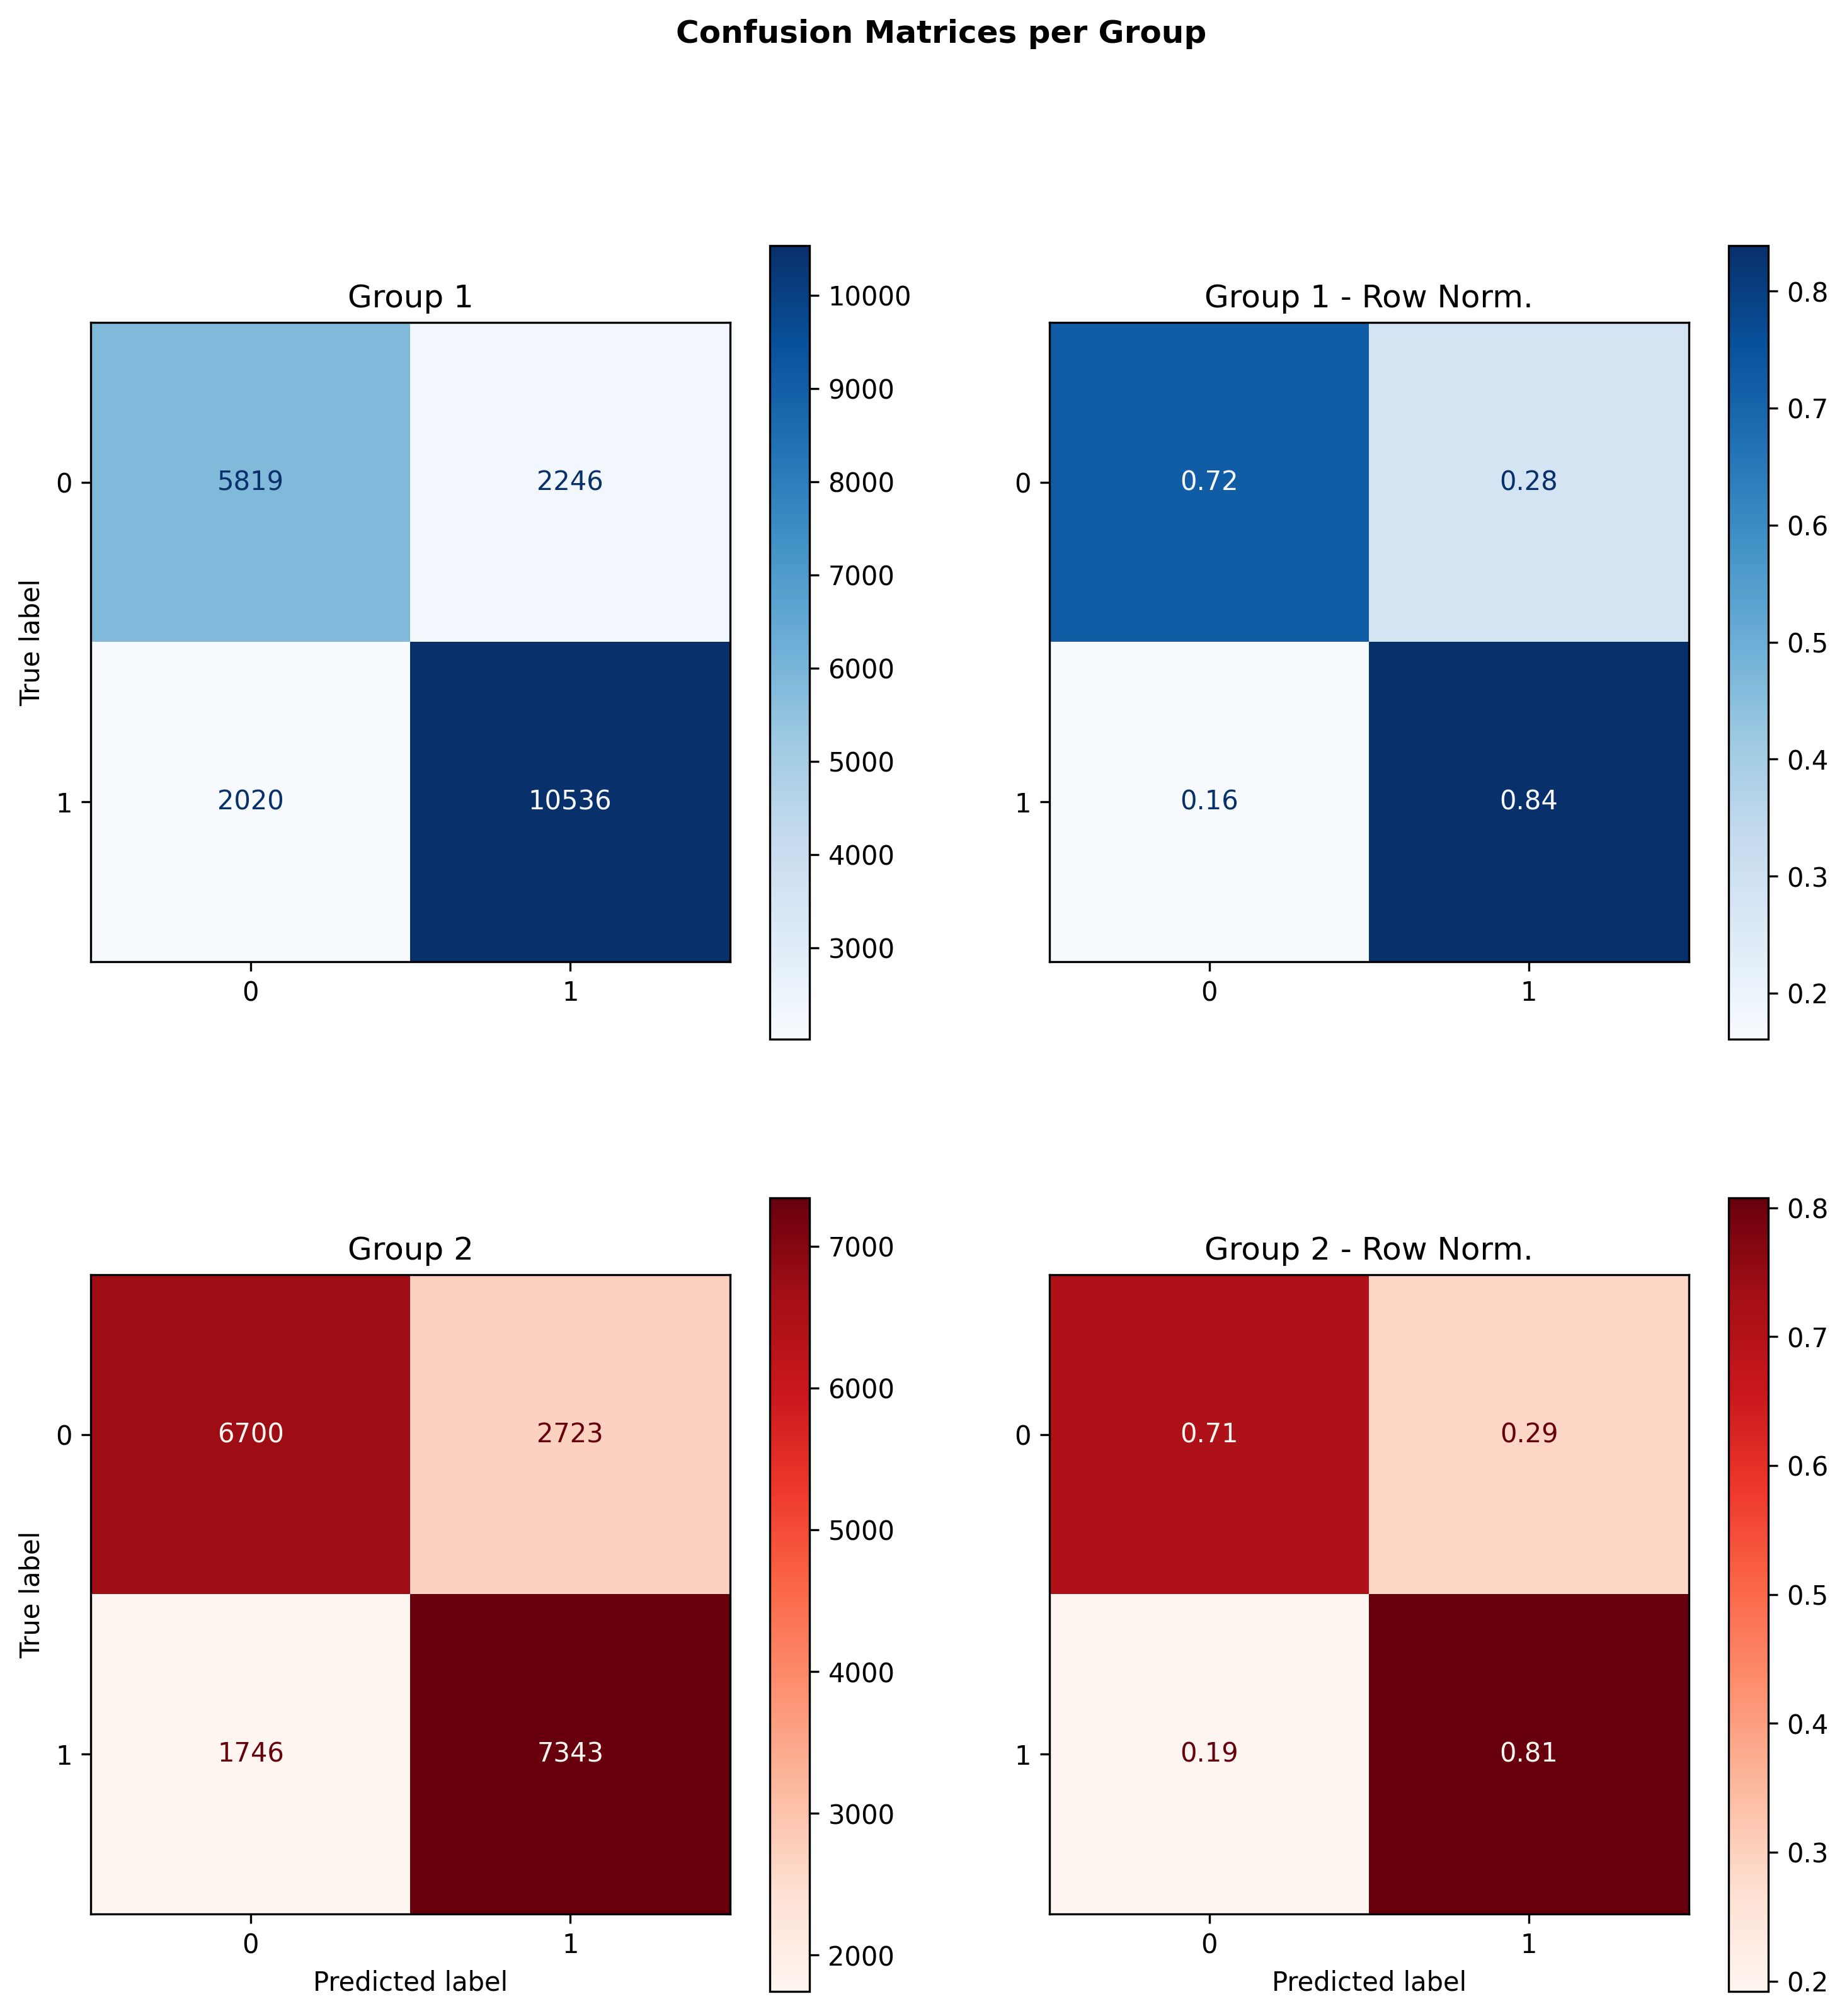

Statistical Parity: False -> (P(s=1 | G=1): 0.620 & P(s=1 | G=2): 0.544)
Equalized Odds: False -> TPR Group 1: 0.839 & TPR Group 2: 0.808 & FPR Group 1: 0.278 & FPR Group 2: 0.289
Equalized Outcomes: False -> P(T=1 | G=1,S=1): 0.824 & P(T=1 | G=2, S=1): 0.729 P(T=1 | G=1, S=0): 0.258 & P(T=1 | G=2, S=0): 0.207


In [18]:
fr = FairnessReport()
fr.fit(y_true = y_test, y_pred = y_hat, group = group_test, pred_prob = pred_probs, index=X_test.index)
fr.compute()

## Task 2 (Explaining white-box models)

### Feature Importance

In [19]:
# Get the coefficients
coefficients = lr.coef_[0]
coef_names = X_train.columns

er = ExplainabilityReport(coefficients, coef_names, FEATURES, model_name="Logistic Regression")
er.get_feature_importance()

,Feature,Import. (%),Coef.,Desc.
34,SCHL_21,11.36,0.756357,Educational attainment: Bachelor's degree
35,SCHL_22,10.28,0.684125,Educational attainment: Master's degree
0,AGEP,8.37,0.557491,None
1,HINS1_2,7.28,-0.484712,Insurance through a current or former employer or union: No
36,SCHL_23,6.18,0.411677,Educational attainment: Professional degree beyond a bachelor's degree
42,SEX_2,6.15,-0.409188,Sex: Female
37,SCHL_24,5.24,0.349090,Educational attainment: Doctorate degree
41,MAR_5,5.11,-0.339991,Marital status: Never married or under 15 years old
3,HINS4_2,4.39,0.292450,"Medicaid, Medical Assistance, or any kind of government-assistance plan for those with low incomes or a disability: No"
33,SCHL_20,4.20,0.279615,Educational attainment: Associate's degree


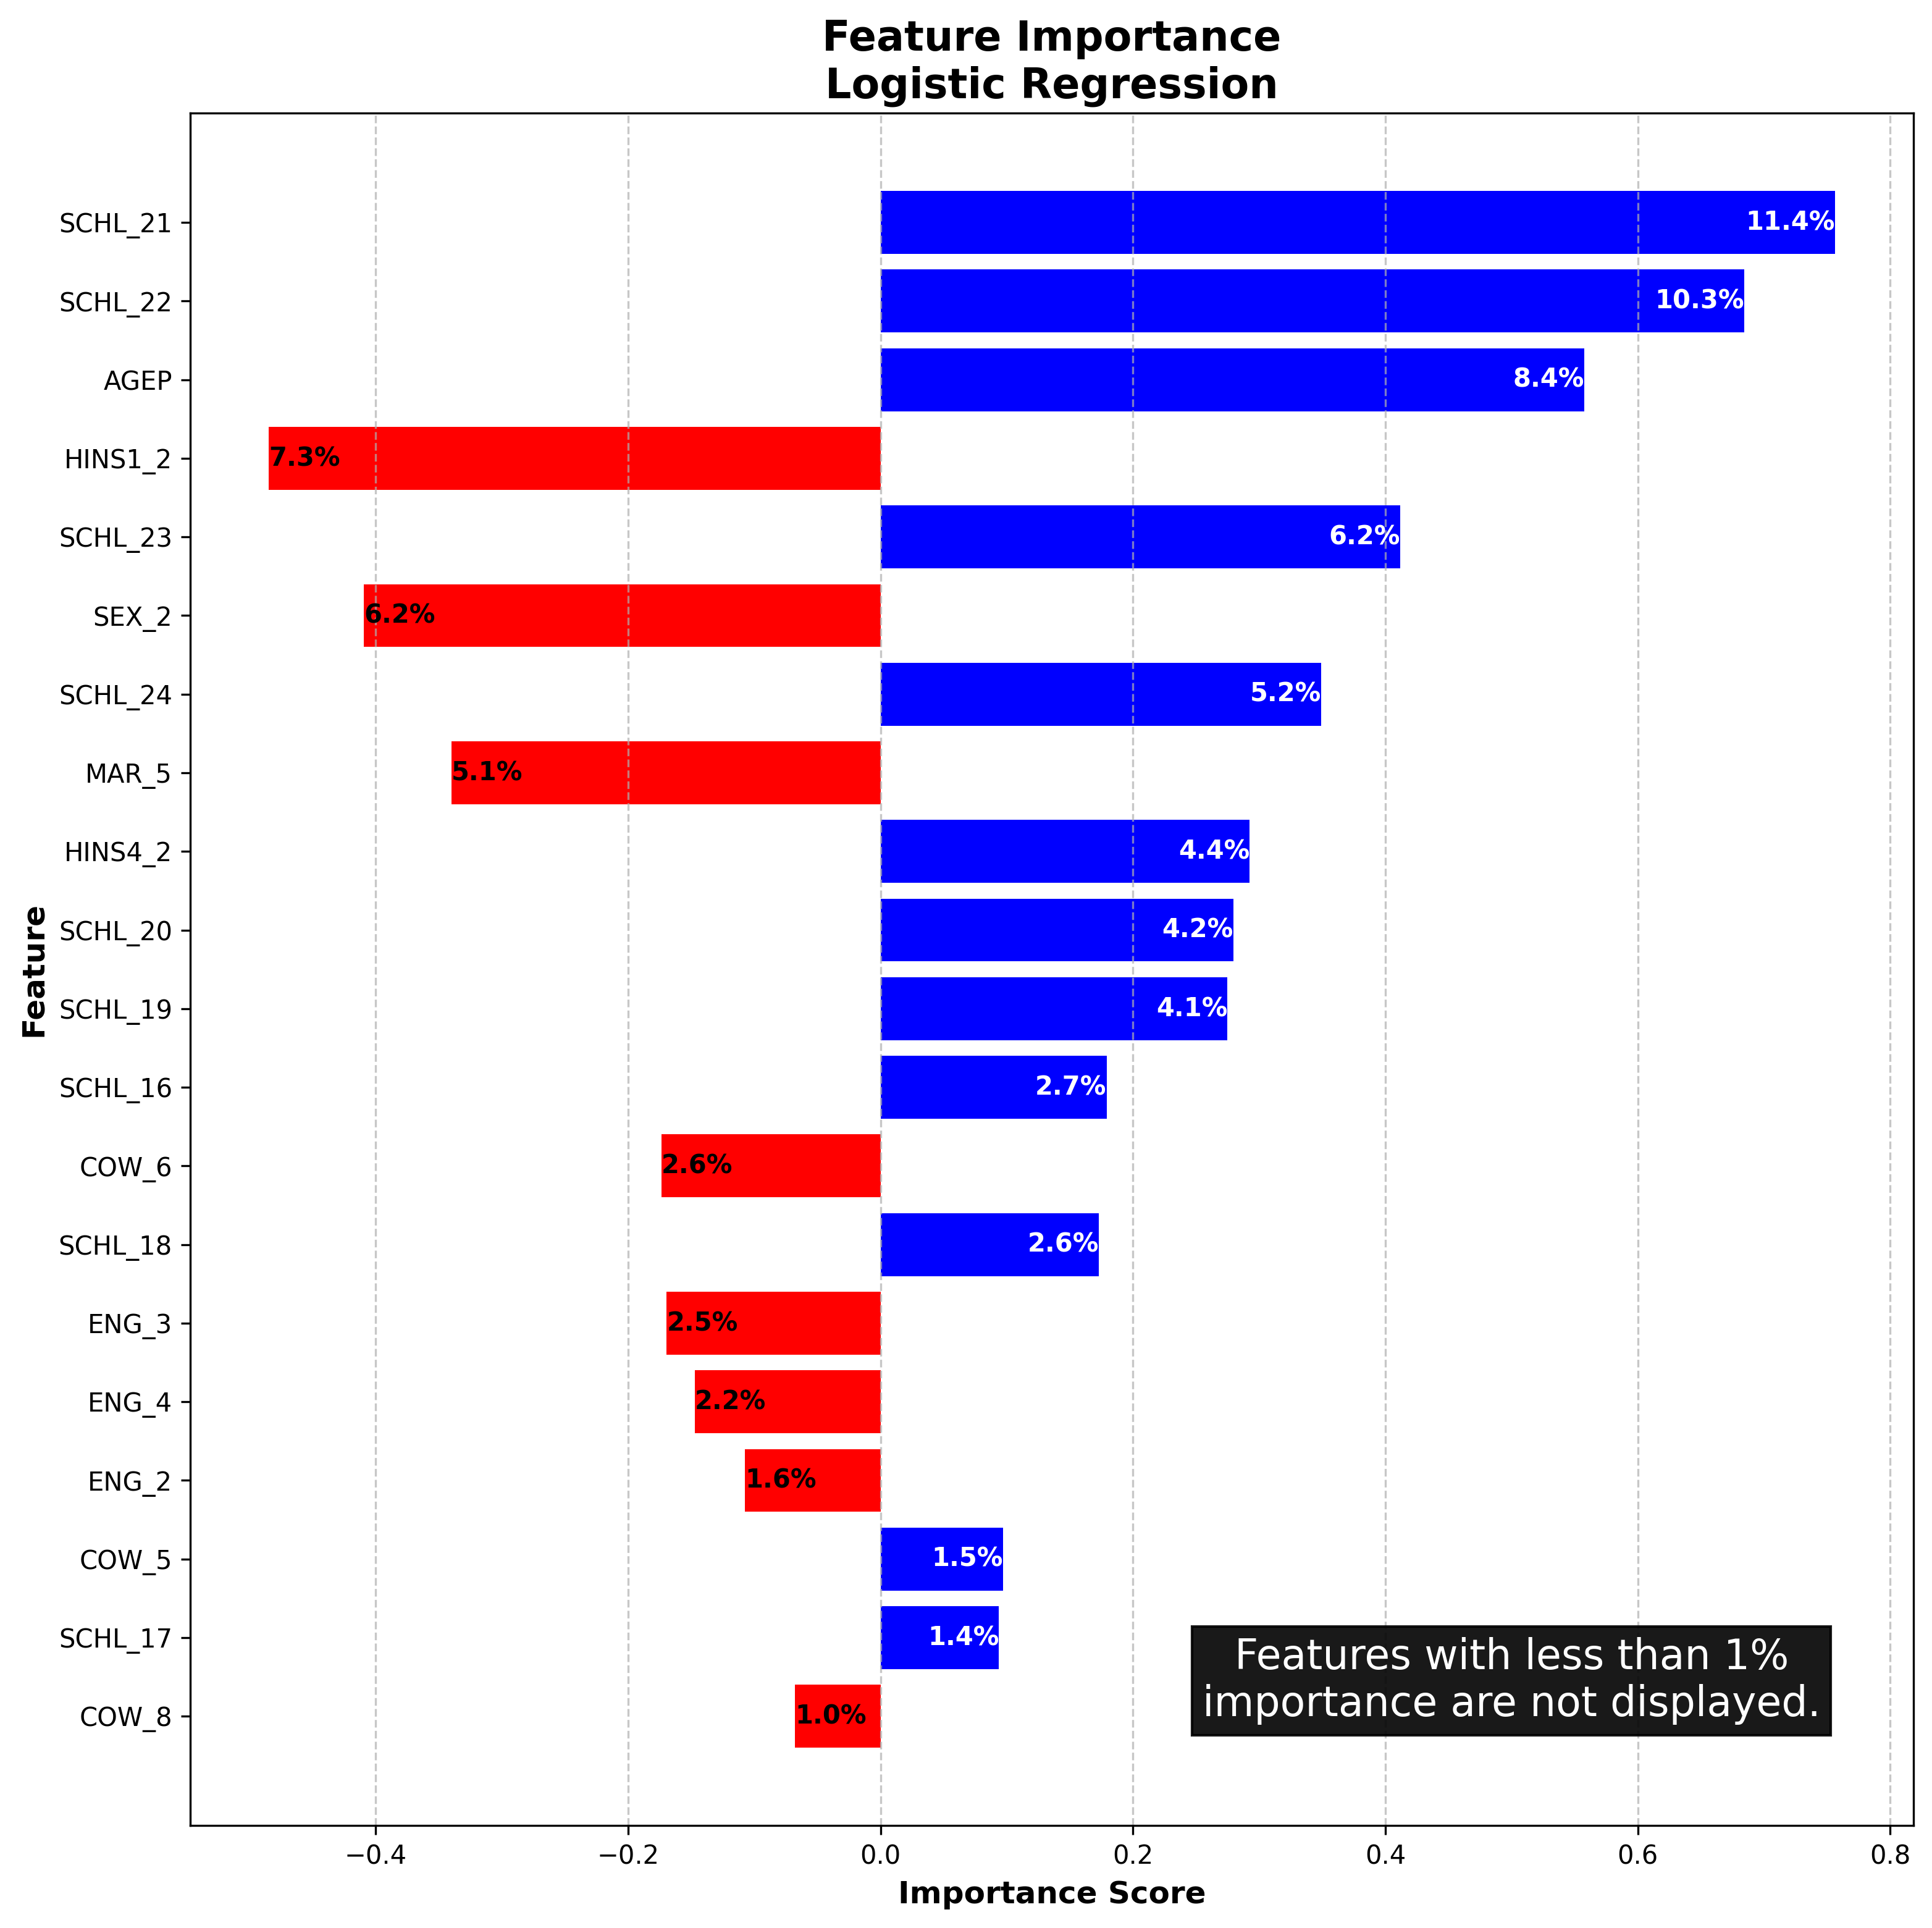

In [20]:
er.plot_feature_importance()

We can observe that accuracy dropped only 2 percent, while the TPR increased from 0.82 to 0.89, meaning that we were able to capture more TRUE positives from the switching labels on the minority group. Nevertheless, the FPR also increased from 0.29 to 0.42, meaning that many of the flipped labels are now INCORRECT predictions.

### Counterfactual example

To find a counterfactual example, we will look at any observation that was predicted TRUE, but with probability close to the threshold, under the assumption that a small change in any of its features could have put the prediction probability under the threshold and thus change the prediction. Then, we will find from the observations predicted as FALSE, the closest to that one found as TRUE.

In [21]:
# Extract the least of features ordered by importance
cols = list(er.get_feature_importance().Feature)
counterfactuals = find_counterfactual(X_test, results, feature_priority=cols, feat_description=FEATURES)
counterfactuals

,374998,140871,Desc.
SCHL_21,0,0,
SCHL_22,0,0,
AGEP,22,22,
HINS1_2,0,0,
SCHL_23,0,0,
SEX_2,0,0,
SCHL_24,0,0,
MAR_5,1,1,
HINS4_2,1,1,
SCHL_20,1,1,


It seems that observation 374998 (predicted positive) and observation 140871 (predicted negative) only differ in that 374998 has bought purchased insurance directly from an insurance company, while observation 140871 hasn't. That difference alone makes the model predict TRUE for observation 374998 (meaning he will make more than 35.000 USD) and observation 140871 FALSE (not making 35.000 USD).

## Task 3 (Model-agnostic explanations)

### SHAP values for white-box classifier

In [34]:
lr_explainer = shap.LinearExplainer(lr, X_train_scaled, feature_names=X_test.columns)
lr_shap_values = lr_explainer(X_test_scaled)

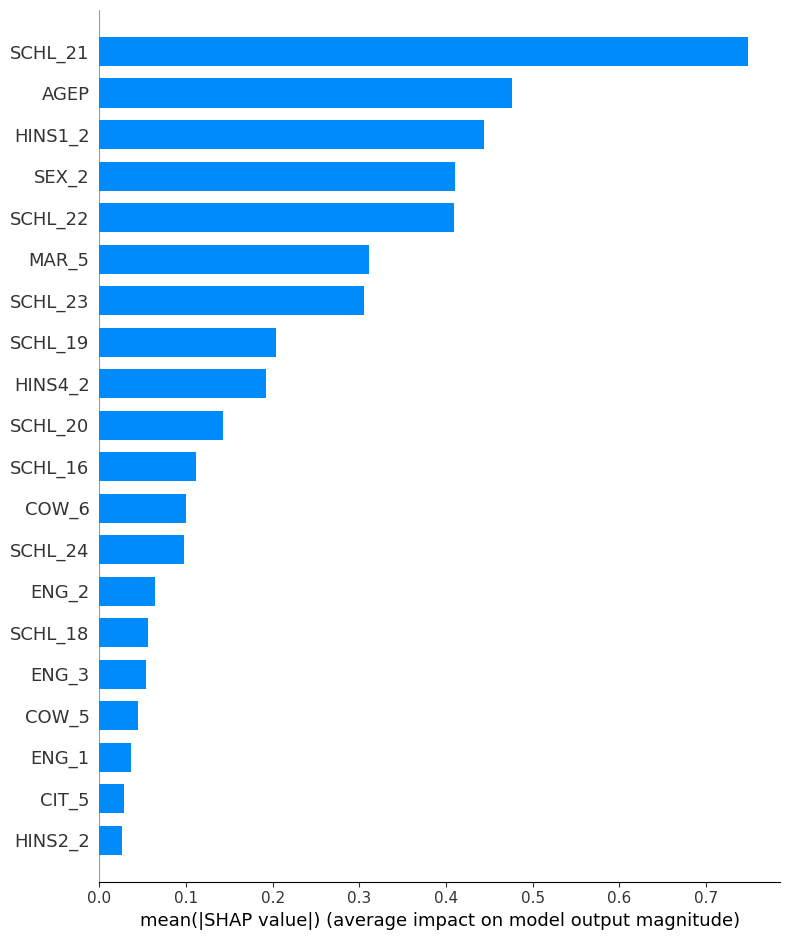

In [115]:
# Summary plot of type "bar" of the SHAP values of the Logistic Regression model
shap.summary_plot(lr_shap_values, X_test_scaled, feature_names=X_test.columns, plot_type="bar")

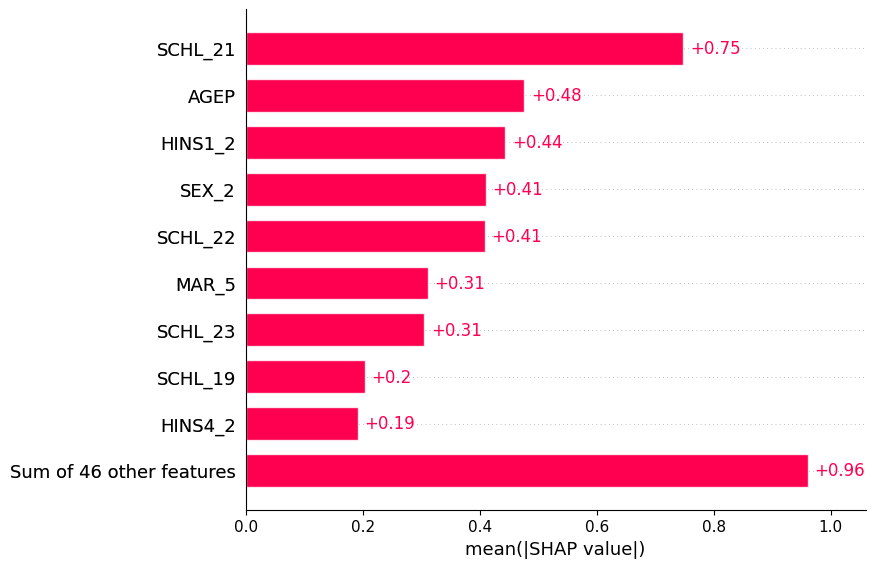

In [119]:
# Bar plot of SHAP values of the Logistic Regression model
shap.plots.bar(lr_shap_values)

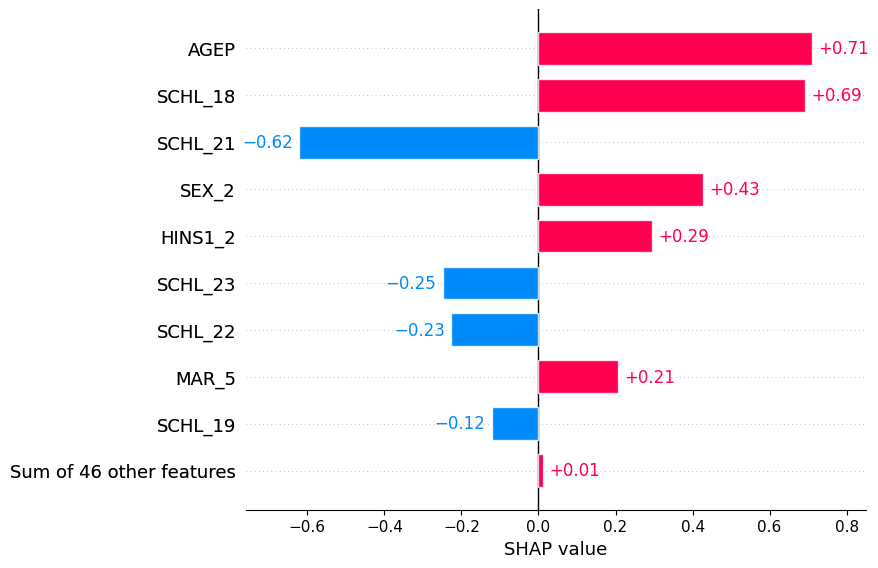

In [85]:
# Bar plot of SHAP values for the first observation of the logistc regression model
shap.plots.bar(lr_shap_values[0])

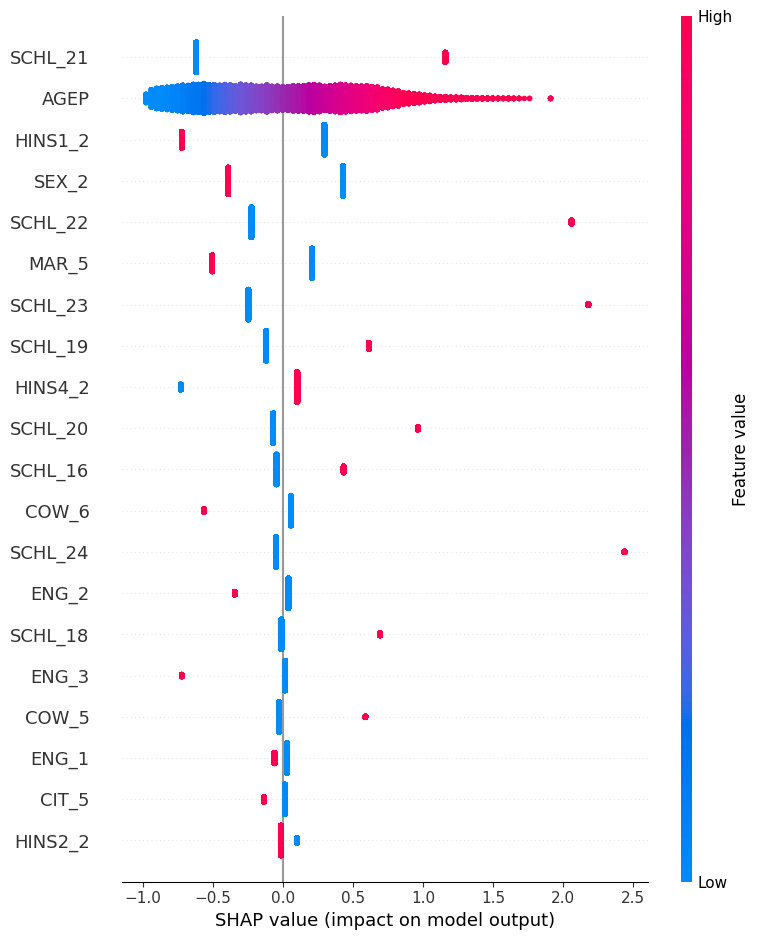

In [116]:
# Summary plot of type "dot" of the SHAP values of the logistic regression
shap.summary_plot(lr_shap_values, X_test_scaled, feature_names=X_test.columns)

### SHAP values for black-box classifier

In [55]:
# This takes ~15 minutes to run
X_train = X_train.astype(float)
rf_explainer = shap.TreeExplainer(rf, X_train, model_output="probability")
rf_shap_values = rf_explainer.shap_values(X_test)

100%|===================| 78198/78266 [15:12<00:00]        

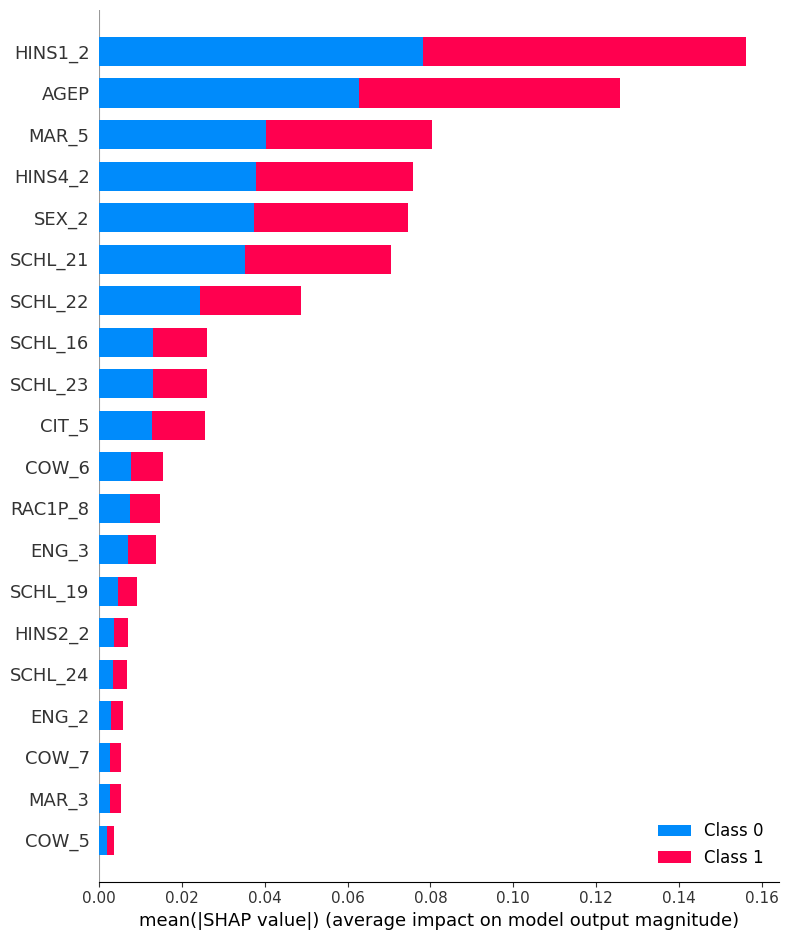

In [109]:
# Summary plot of type "bar" of the SHAP values of the Random Forest model
shap.summary_plot(rf_shap_values, X_test, feature_names=X_test.columns, plot_type='bar')

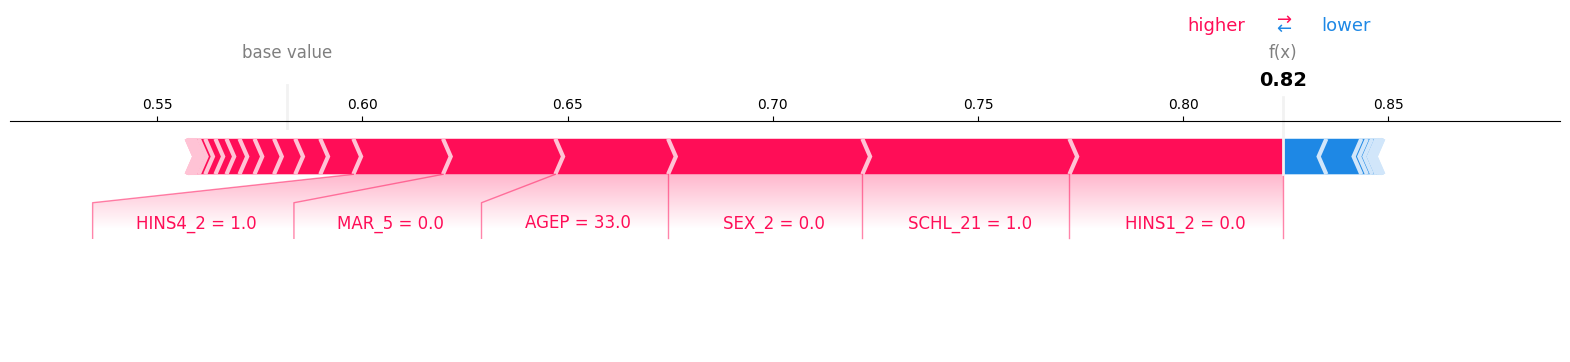

In [114]:
# Force plot for the first observation of the Random Forest model
shap.plots.force(rf_explainer.expected_value[1], rf_shap_values[1][1,:], X_test.iloc[1, :], matplotlib = True)

In [120]:
# Dependence plot for the feature "AGEP" of the Random Forest model
